In [1]:
# import required modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import collections
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pickle

In [2]:
data = pd.read_csv("~/Downloads/archive/hacker_news_sample.csv")
data

,title,url,text,dead,by,score,time,type,id,parent,descendants,ranking,deleted,timestamp
0,NaN,NaN,&gt;<i>which leads me to say why are you using...,NaN,coldtea,NaN,1.390844e+09,comment,7131680,7127578.0,NaN,NaN,NaN,2014-01-27T17:31:13Z
1,NaN,NaN,I would like to point out some counter-example...,NaN,etanol,NaN,1.319396e+09,comment,3146879,3145330.0,NaN,NaN,NaN,2011-10-23T18:46:40Z
2,NaN,NaN,NaN,NaN,NaN,NaN,1.456641e+09,comment,11190089,11189361.0,NaN,NaN,True,2016-02-28T06:26:56Z
3,NaN,NaN,<i>Our msbuild implementation can now build Pr...,NaN,Locke1689,NaN,1.407882e+09,comment,8170491,8170071.0,NaN,NaN,NaN,2014-08-12T22:13:10Z
4,NaN,NaN,No matter how awful iPhoto is it's still bette...,NaN,miloshadzic,NaN,1.362573e+09,comment,5330773,5327590.0,NaN,NaN,NaN,2013-03-06T12:28:02Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659692,NaN,NaN,"They are still on book #79 ""Mystery of the Sac...",NaN,mynameishere,NaN,1.189823e+09,comment,54809,54631.0,NaN,NaN,NaN,2007-09-15T02:31:03Z
3659693,NaN,NaN,I&#x27;d argue rather it&#x27;s copyright law ...,NaN,ajarmst,NaN,1.434245e+09,comment,9713452,9711891.0,NaN,NaN,NaN,2015-06-14T01:23:00Z
3659694,NaN,NaN,that&#x27;s my startup! boom,True,woah,NaN,1.378690e+09,comment,6351340,6351046.0,NaN,NaN,NaN,2013-09-09T01:23:08Z
3659695,NaN,NaN,For one there&#x27;s less worry that you&#x27;...,NaN,aqme28,NaN,1.425258e+09,comment,9129747,9129736.0,NaN,NaN,NaN,2015-03-02T01:07:19Z


In [3]:
test_data_titles = data.loc[data.type == "story"].title.fillna("")

In [6]:
test_data_titles.apply(lambda x : len(x)).sum() / 4

7153899.5

In [3]:
# get number of stories and comments
d2 = data.copy()
num_story = d2.loc[d2.type == "story", "type"].count()
num_comment = d2.loc[d2.type == "comment", "type"].count()
print(num_story, num_comment)

653757 3000341


In [4]:
# group data by score
d3 = d2.loc[d2.type == "story"]
score_freq = d3.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')

c:\Users\Ethan\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


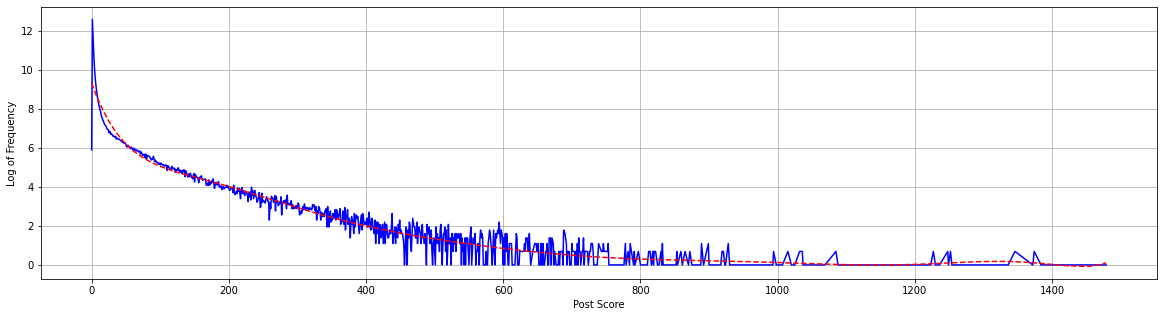

In [5]:
# plot direct distribution of scores

d4 = score_freq.loc[score_freq.score < 1500]
d4.frequency = np.log(d4.frequency)
x_axis = d4.score
y_axis = d4.frequency
plt.figure(figsize = (20, 5))
plt.plot(x_axis, y_axis, "b")
plt.grid()
z = np.polyfit(x_axis, y_axis, 10)
p = np.poly1d(z)
plt.plot(x_axis,p(x_axis),"r--")
plt.xlabel("Post Score")
plt.ylabel("Log of Frequency")
plt.show()

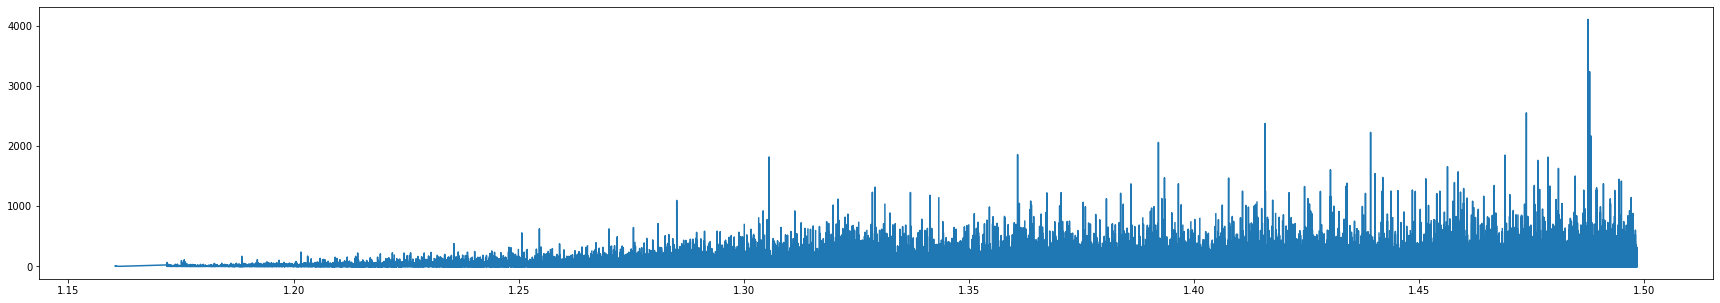

In [6]:
# group score over time

d5 = d2.loc[d2.type == "story"]
score_over_time = d5.groupby(["time"])["score"].mean().reset_index(name='average_score')
score_over_time["time"] = score_over_time["time"] / np.power(10,9)
plt.figure(figsize = (30, 5))
plt.plot(score_over_time["time"], score_over_time["average_score"])
plt.show()

In [7]:
# combine unix times into groups
score_over_time
group_size = 0.0001
bottom = score_over_time["time"].min()
group_score = 0
group_count = 0
groups = []
i = bottom
while i <= score_over_time["time"].max():
    group_score = 0
    group_count = 0
    for time in score_over_time["time"]:
        if time < i:
            continue
        elif time > i + 0.1:
            break
        else:
            group_score += time
            group_count += 1
    groups.append(group_score / group_count)
    i += group_size

plt.figure(figsize = (20, 5))
plt.plot(np.arange(len(groups)), groups)
plt.xlabel("group number")
plt.ylabel("average score")
plt.show()

In [ ]:
# convert unix timestamps to datetime
def convert_time_to_date(times):
    for i in times.index:
        if times[i] > 0:
            times[i] = datetime.datetime.fromtimestamp(times[i])
    return times

stories = d2.loc[d2["type"] == "story"]
stories = stories.loc[stories["time"] > 0]
times = stories["time"]
new_times = convert_time_to_date(times)
data_with_dates = stories.copy()
data_with_dates["time"] = new_times


In [ ]:
# group by day
grouped_by_dates = data_with_dates[["time", "score"]]
resampled_dates_on_day = grouped_by_dates.resample('D', on ="time")
avg_score_per_day = resampled_dates_on_day.mean()
total_score_per_day = resampled_dates_on_day.sum()
count_score_per_day = resampled_dates_on_day.count()
median_score_per_day = resampled_dates_on_day.median()
print(avg_score_per_day)
print(total_score_per_day)

In [ ]:
print(avg_score_per_day["score"].keys())
print(avg_score_per_day["score"].values)
print(len(avg_score_per_day["score"].values))

In [ ]:
# remove NaN 

avg_score_per_day = avg_score_per_day.dropna()
total_score_per_day = total_score_per_day.dropna()
count_score_per_day = count_score_per_day.dropna()
median_score_per_day = median_score_per_day.dropna()

plt.figure(figsize = (20, 5))
plt.scatter(avg_score_per_day["score"].keys(), avg_score_per_day["score"], s = 5)
plt.xlabel("Time")
plt.ylabel("Average Post Score per day")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(total_score_per_day["score"].keys(), np.log(total_score_per_day["score"]), s = 5)
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per day")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(count_score_per_day["score"].keys(), np.log(count_score_per_day["score"]), s = 5)
plt.xlabel("Time")
plt.ylabel("Log of number of posts per day")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(median_score_per_day["score"].keys(), np.log(median_score_per_day["score"]))
plt.xlabel("Time")
plt.ylabel("Log of Media Post Score per day")
plt.show()

In [ ]:
resampled_dates_on_month = grouped_by_dates.resample('M', on ="time")
resampled_dates_on_year = grouped_by_dates.resample('Y', on ="time")
avg_score_per_month = resampled_dates_on_month.mean()
total_score_per_month = resampled_dates_on_month.sum()
count_score_per_month = resampled_dates_on_month.count()
median_score_per_month = resampled_dates_on_month.median()
avg_score_per_year = resampled_dates_on_year.mean()
total_score_per_year = resampled_dates_on_year.sum()
count_score_per_year = resampled_dates_on_year.count()
median_score_per_year = resampled_dates_on_year.median()

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(avg_score_per_month["score"].keys(), avg_score_per_month["score"])
plt.xlabel("Time")
plt.ylabel("Average Post Score per month")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(total_score_per_month["score"].keys(), np.log(total_score_per_month["score"]))
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per month")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(count_score_per_month["score"].keys(), np.log(count_score_per_month["score"]))
plt.xlabel("Time")
plt.ylabel("Log of number of posts per month")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(avg_score_per_year["score"].keys(), avg_score_per_year["score"])
plt.xlabel("Time")
plt.ylabel("Average Post Score per year")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(total_score_per_year["score"].keys(), np.log(total_score_per_year["score"]))
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per year")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(count_score_per_year["score"].keys(), np.log(count_score_per_year["score"]))
plt.xlabel("Time")
plt.ylabel("Log of number of posts per year")
plt.show()

In [ ]:
training_data_rand = data.sample(frac = 0.7, random_state=25)
testing_data_rand = data.drop(training_data_rand.index)

training_data_cutoff = data_with_dates.loc[data_with_dates["time"] <= datetime.datetime(2015, 1, 1)]
testing_data_cutoff = data_with_dates.drop(training_data_cutoff.index)

print(training_data_cutoff["time"])
print(testing_data_cutoff["time"])


In [ ]:
print(len(training_data_rand))
print(len(testing_data_rand))

In [ ]:
training_score_freq = training_data_rand.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')
training_score_freq_2 = training_data_cutoff.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(training_score_freq["score"], np.log(training_score_freq["frequency"]))
plt.xlabel("score")
plt.ylabel("Log of frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq_2["score"], np.log(training_score_freq_2["frequency"]))
plt.xlabel("score")
plt.ylabel("Log of frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq.loc[training_score_freq["score"] <= 1500]["score"], np.log(training_score_freq.loc[training_score_freq["score"] <= 1500]["frequency"]))
plt.xlabel("score")
plt.ylabel("Log of frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["score"], np.log(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["frequency"]))
plt.xlabel("score")
plt.ylabel("Log of frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(np.log(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["score"]), np.log(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["frequency"]))
plt.xlabel("Log of score")
plt.ylabel("Log of frequency")
plt.show()

In [ ]:
old_times_training = training_data_rand["time"].dropna()
old_times_testing = testing_data_rand["time"].dropna()

new_times_training = convert_time_to_date(old_times_training)
new_times_testing = convert_time_to_date(old_times_testing)


training_data_rand["dates"] = new_times_training
testing_data_rand["dates"] = new_times_testing
training_data_cutoff["dates"] = training_data_cutoff["time"]

training_data_rand

In [ ]:
time_mean_rand = training_data_rand[["dates", "score"]]
time_mean_rand = time_mean_rand.dropna()
score_over_hours = time_mean_rand.groupby(lambda x : time_mean_rand["dates"][x].hour)["score"]
score_over_minutes = time_mean_rand.groupby(lambda x : datetime.time(time_mean_rand["dates"][x].hour, time_mean_rand["dates"][x].minute))["score"]

In [ ]:
score_over_hours_mean = score_over_hours.mean()
score_over_hours_total = score_over_hours.sum()
score_over_hours_count = score_over_hours.count()
score_over_minutes_mean = score_over_minutes.mean()
score_over_minutes_total = score_over_minutes.sum()
score_over_minutes_count = score_over_minutes.count()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_mean.keys(), score_over_hours_mean.values)
plt.xlabel("time (hours)")
plt.ylabel("Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_total.keys(), score_over_hours_total.values)
plt.xlabel("time (hours)")
plt.ylabel("Total Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_count.keys(), score_over_hours_count.values)
plt.xlabel("time (hours)")
plt.ylabel("Number of Posts")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_mean.keys())), score_over_minutes_mean.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_total.keys())), score_over_minutes_total.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Total Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_count.keys())), score_over_minutes_count.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Number of Posts")
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))
score_threshold = 650
score_threshold_2 = 20

training_data_rand_stories_good = training_data_rand.loc[(training_data_rand.type == "story") & (training_data_rand.score >= score_threshold)]
training_data_rand_stories_bad = training_data_rand.loc[(training_data_rand.type == "story") & (training_data_rand.score < score_threshold)]
training_data_rand_stories_good_2 = training_data_rand.loc[(training_data_rand.type == "story") & (training_data_rand.score >= score_threshold_2)]
training_data_rand_stories_bad_2 = training_data_rand.loc[(training_data_rand.type == "story") & (training_data_rand.score < score_threshold_2)]


In [ ]:
training_data_rand_stories_text_good = training_data_rand_stories_good["text"].dropna()
training_data_rand_stories_text_bad = training_data_rand_stories_bad["text"].dropna()
training_data_rand_stories_text_good_2 = training_data_rand_stories_good_2["text"].dropna()
training_data_rand_stories_text_bad_2 = training_data_rand_stories_bad_2["text"].dropna()
most_common_in_text_good = Counter([w for w in " ".join(training_data_rand_stories_text_good.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_text_bad = Counter([w for w in " ".join(training_data_rand_stories_text_bad.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_text_good_2 = Counter([w for w in " ".join(training_data_rand_stories_text_good_2.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_text_bad_2 = Counter([w for w in " ".join(training_data_rand_stories_text_bad_2.str.lower()).split() if w not in stop_words]).most_common(100)

In [ ]:
training_data_rand_stories_titles_good = training_data_rand_stories_good["title"].dropna()
training_data_rand_stories_titles_bad = training_data_rand_stories_bad["title"].dropna()
training_data_rand_stories_titles_good_2 = training_data_rand_stories_good_2["title"].dropna()
training_data_rand_stories_titles_bad_2 = training_data_rand_stories_bad_2["title"].dropna()
most_common_in_title_good = Counter([w for w in " ".join(training_data_rand_stories_titles_good.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_title_bad = Counter([w for w in " ".join(training_data_rand_stories_titles_bad.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_title_good_2 = Counter([w for w in " ".join(training_data_rand_stories_titles_good_2.str.lower()).split() if w not in stop_words]).most_common(100)
most_common_in_title_bad_2 = Counter([w for w in " ".join(training_data_rand_stories_titles_bad_2.str.lower()).split() if w not in stop_words]).most_common(100)

In [ ]:
if 0:
    with open("good_words_title", "wb") as fb:
        pickle.dump(most_common_in_title_good_2, fb)

    with open("bad_words_title", "wb") as fb:
        pickle.dump(most_common_in_title_bad_2, fb)

    with open("good_words_text", "wb") as fb:
        pickle.dump(most_common_in_text_good_2, fb)

    with open("bad_words_text", "wb") as fb:
        pickle.dump(most_common_in_text_bad_2, fb)

In [ ]:
print("TEXT-GOOD\n", most_common_in_text_good, "\n")
print("TEXT-BAD\n", most_common_in_text_bad, "\n")
print("TITLES-GOOD\n", most_common_in_title_good, "\n")
print("TITLES-BAD\n", most_common_in_title_bad, "\n")

In [ ]:
print("TEXT-GOOD\n", most_common_in_text_good_2, "\n")
print("TEXT-BAD\n", most_common_in_text_bad_2, "\n")
print("TITLES-GOOD\n", most_common_in_title_good_2, "\n")
print("TITLES-BAD\n", most_common_in_title_bad_2, "\n")

In [ ]:
common_in_text = [(w,n,m) for (w,n) in most_common_in_text_good for (w2,m) in most_common_in_text_bad if w == w2]
common_in_title = [(w,n,m) for (w,n) in most_common_in_title_good for (w2,m) in most_common_in_title_bad if w == w2]

print("Text:", len(common_in_text))
print(common_in_text)
print("")
print("Titles:", len(common_in_title))
print(common_in_title)

In [ ]:
comments_rand = training_data_rand[["descendants", "score"]]
comments__rand = comments_rand.dropna()
score_against_comments = comments_rand.groupby(comments_rand["descendants"])["score"]

In [ ]:
score_against_comments_mean = score_against_comments.mean()
score_against_comments_total = score_against_comments.sum()
score_against_comments_count = score_against_comments.count()


plt.figure(figsize = (20, 5))
plt.plot(score_against_comments_mean.keys(), score_against_comments_mean.values)
plt.xlabel("Number of Comments")
plt.ylabel("Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_against_comments_mean.keys(), np.log(score_against_comments_mean.values))
plt.xlabel("Number of Comments")
plt.ylabel("Log Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(np.log(score_against_comments_mean.keys()), np.log(score_against_comments_mean.values))
plt.xlabel("Log Number of Comments")
plt.ylabel("Log Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_against_comments_total.keys(), np.log(score_against_comments_total.values))
plt.xlabel("Number of Comments")
plt.ylabel("Log Total Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_against_comments_count.keys(), np.log(score_against_comments_count.values))
plt.xlabel("Number of Comments")
plt.ylabel("Log Number of Posts")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(np.log(score_against_comments_count.keys()), np.log(score_against_comments_count.values))
plt.xlabel("Log Number of Comments")
plt.ylabel("Log Number of Posts")
plt.show()



In [ ]:
from cmath import nan


training_data_rand_stories = training_data_rand.loc[training_data_rand.type == "story"]
stories_with_url = training_data_rand_stories.loc[training_data_rand_stories.url.notnull()]
stories_without_url = training_data_rand_stories.loc[~training_data_rand_stories.url.notnull()]
stories_without_url = stories_without_url.loc[stories_without_url.deleted != True]
stories_with_text = training_data_rand_stories.loc[training_data_rand_stories.text.notnull()]
stories_without_text = training_data_rand_stories.loc[~training_data_rand_stories.text.notnull()]
stories_with_url_and_with_text = stories_with_url.loc[stories_with_url.text.notnull()]
stories_with_url_and_without_text = stories_with_url.loc[~stories_with_url.text.notnull()]
stories_without_url_and_with_text = stories_without_url.loc[stories_without_url.text.notnull()]
stories_without_url_and_without_text = stories_without_url.loc[~stories_without_url.text.notnull()]

In [ ]:
print("with/without url mean")


print("url -", stories_with_url.score.mean())
print("not url -", stories_without_url.score.dropna().mean())
print("text -", stories_with_text.score.mean())
print("not text -", stories_without_text.score.dropna().mean())

print("\nwith/without url/text count")

print("url -", stories_with_url.score.count())
print("not url -", stories_without_url.score.count())
print("text -", stories_with_text.score.count())
print("not text -", stories_without_text.score.count())

print("\nmean")

print("url+text -", stories_with_url_and_with_text.score.mean())
print("url -", stories_with_url_and_without_text.score.mean())
print("text -", stories_without_url_and_with_text.score.mean())
print("none -", stories_without_url_and_without_text.score.mean())

print("\nmedian")

print("url+text -", stories_with_url_and_with_text.score.median())
print("url -",stories_with_url_and_without_text.score.median())
print("text -", stories_without_url_and_with_text.score.median())
print("none -",stories_without_url_and_without_text.score.median())

print("\nmin")

print("url+text -",stories_with_url_and_with_text.score.min())
print("url -",stories_with_url_and_without_text.score.min())
print("text -",stories_without_url_and_with_text.score.min())
print("none -",stories_without_url_and_without_text.score.min())

print("\nmax")

print("url+text -",stories_with_url_and_with_text.score.max())
print("url -",stories_with_url_and_without_text.score.max())
print("text -",stories_without_url_and_with_text.score.max())
print("none -",stories_without_url_and_without_text.score.max())

print("\ncount")

print("url+text -",stories_with_url_and_with_text.score.count())
print("url -",stories_with_url_and_without_text.score.count())
print("text -",stories_without_url_and_with_text.score.count())
print("none -",stories_without_url_and_without_text.score.count())

In [ ]:
ax1 = [np.log(stories_with_url.score), np.log(stories_without_url.score.dropna()), np.log(stories_with_text.score), np.log(stories_without_text.score.dropna())]
ax2 = [np.log(stories_with_url_and_with_text.score.dropna()), np.log(stories_with_url_and_without_text.score.dropna()), np.log(stories_without_url_and_with_text.score.dropna()), np.log(stories_without_url_and_without_text.score.dropna())]

plt.figure(figsize = (20, 5))
plt.boxplot(ax1, vert = False)
plt.xlabel("Log of Score")
plt.yticks([1, 2, 3, 4], ["with urls", "without urls", "with text", "without text"])
plt.show()

plt.figure(figsize = (20, 5))
plt.boxplot(ax2, vert = False)
plt.yticks([1,2,3,4], ["urls and text", "urls only", "text only", "neither urls or text"])
plt.xlabel("Log of Score")
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.boxplot(np.log(training_data_rand_stories.score.dropna()), vert = False)
plt.xlabel("Log of Score")
plt.show()


In [ ]:
#import sklearn
#from sklearn.linear_model import LinearRegression

In [ ]:
def less_than_date(input):
    x = input.dates < datetime.datetime(2013, 1, 1)
    return [int(k) for k in x]

def has_url(input):
    x = input.url.isna()
    return [int(k) for k in x]

def has_title(input):
    x = input.title.isna()
    return [int(k) for k in x]

def contains_word_text(input, word):
    out = []
    for(index, row) in input.iterrows():
        if isinstance(row.text, str):
            out.append(int(word in row.text.split(" ")))
            continue
        out.append(0)
    return out

def contains_word_title(input, word):
    out = []
    for(index, row) in input.iterrows():
        if isinstance(row.text, str):
            out.append(int(word in row.title.split(" ")))
            continue
        out.append(0)
    return out

In [ ]:
t = less_than_date(training_data_rand_stories)
has_u = has_url(training_data_rand_stories)
has_t = has_title(training_data_rand_stories)
has_w = [contains_word_text(training_data_rand_stories, word) for word in most_common_in_text_good[:10]]


In [ ]:
final = []
for i in range(0, len(t)):
    temp = []
    temp.append(1)
    temp.append(t[i])
    temp.append(has_u[i])
    temp.append(has_t[i])
    for l in has_w:
        temp.append(l[i])
    final.append(temp)
final

In [ ]:
def create_x(input):
    t = less_than_date(input)
    has_u = has_url(input)
    has_t = has_title(input)
    has_w = [contains_word_text(input, word) for word in most_common_in_text_good[:50]] 

    final = []
    for i in range(0, len(t)):
        temp = []
        temp.append(1)
        temp.append(t[i])
        temp.append(1 - t[i])
        temp.append(has_u[i])
        temp.append(has_t[i])
        for l in has_w:
            temp.append(l[i])
        final.append(temp)
    return final

In [ ]:
#print(len(training_data_rand_stories), len(create_x(training_data_rand_stories)))

In [ ]:
import requests

In [ ]:
# get_page_rank
api_url = "https://openpagerank.com/api/v1.0/"
req = requests.get(url=api_url, )
print(req.json())

In [ ]:
simple_model = LinearRegression()
y = list(training_data_rand_stories.score)
y = [x if x >= 0 else 0 for x in y]
simple_model.fit(create_x(training_data_rand_stories), y)

In [ ]:
simple_model_2 = LinearRegression()
y2 = list(training_data_rand_stories.score)
y2 = [1 if x >= 20 else 0 for x in y2]
simple_model_2.fit(create_x(training_data_rand_stories), y2)

In [ ]:
with open("../data/training_data", "wb") as fb:
    pickle.dump(training_data_rand, fb)

with open("testing_data", "wb") as fb:
    pickle.dump(testing_data_rand, fb)